In [1]:
from pathlib import Path
import pandas as pd
from seiz_eeg.dataset import EEGDataset

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

from torch_geometric.nn import GCNConv

from training import train
from utils import display_metrics, count_parameters, seed_everything
from preprocessing import normalize_z_score

In [2]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "/home/ogut/data"

DATA_ROOT = Path(data_path)

In [3]:
seed_everything(1)

In [4]:
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")
clips_te = pd.read_parquet(DATA_ROOT / "test/segments.parquet")

In [5]:
"""
Based on https://www.sciencedirect.com/science/article/pii/S1746809422004098#fig4
"""

class SlidingWindowBatch(nn.Module):
    #TODO assert last window shape
    def __init__(self, window_size=125, step_size=62):
        super().__init__()
        self.window_size = window_size
        self.step_size = step_size

    def forward(self, data):
        batch_size, signal_len, channels = data.shape
        num_windows = (signal_len - self.window_size) // self.step_size + 1

        windows = []
        for i in range(num_windows):
            start = i * self.step_size
            end = start + self.window_size
            window = data[:, start:end, :]  # shape: (batch_size, window_size, 19)
            windows.append(window)

        windows = torch.stack(windows, dim=1)  # shape: (batch_size, num_windows, window_size, 19)
        return windows.transpose(-2,-1) # shape: (batch_size, num_windows, 19, window_size)

class GCNLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels=32):
        super().__init__()

        self.gcn1 = GCNConv(in_channels=in_channels, out_channels=hidden_channels)

        self.gcn2 = GCNConv(in_channels=hidden_channels, out_channels=hidden_channels)

        self.activation = nn.GELU()
        
    def forward(self, x, edge_index):
        # First GAT layer
        x = self.gcn1(x, edge_index)  # shape: (batch_size * num_windows, 19, hidden_channels * num_heads_1)
        
        x = self.activation(x)

        # Second GAT layer with 1 attention head
        x = self.gcn2(x, edge_index)  # shape: (batch_size * num_windows, 19, hidden_channels)
        
        return x
    
class TemporalAttention(nn.Module):
    def __init__(self, hidden_dim, attn_dim):
        """
        Args:
            hidden_dim: dimension of BiLSTM output (hidden_size * 2 if BiLSTM)
            attn_dim: dimension of intermediate MLP hidden layer
        """
        super().__init__()
        self.attention_mlp = nn.Linear(hidden_dim, attn_dim)
        self.context_vector = nn.Parameter(torch.randn(attn_dim))

    def forward(self, h):
        """
        Args:
            h: Tensor of shape (batch_size, seq_len, hidden_dim)
        
        Returns:
            s: Tensor of shape (batch_size, hidden_dim)
        """
        # Step 1: compute ut = tanh(Wh + b)
        u = torch.tanh(self.attention_mlp(h))  # (batch_size, seq_len, attn_dim)

        # Step 2: compute scores: dot(u_t, u_w)
        # context_vector: (attn_dim,)
        scores = torch.matmul(u, self.context_vector)  # (batch_size, seq_len)

        # Step 3: softmax over time
        alpha = F.softmax(scores, dim=1)  # (batch_size, seq_len)

        # Step 4: weighted sum of h
        s = torch.bmm(alpha.unsqueeze(1), h)  # (batch_size, 1, hidden_dim)
        s = s.squeeze(1)  # (batch_size, hidden_dim)

        return s

class CombinedModel(nn.Module):
    def __init__(self, gcn_in_features=64, gcn_out_features=32, output_size=1, window_size=125, step_size=62, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64):
        super().__init__()

        # Sliding window batch layer
        self.sliding_window = SlidingWindowBatch(window_size=window_size, step_size=step_size)

        # Projection layer from 125 to 64 features
        self.projection = nn.Linear(window_size, gcn_in_features)

        # GAT layers
        self.gcn = GCNLayer(in_channels=gcn_in_features, hidden_channels=gcn_out_features)

        # Flattening the output and passing through a fully connected layer before BiLSTM
        self.fc = nn.Linear(19 * gcn_out_features, lstm_input_size)  # 19 nodes * 32 features per node

        # BiLSTM
        self.bilstm = nn.LSTM(input_size=lstm_input_size, hidden_size=lstm_hidden_size, num_layers=3, batch_first=True, bidirectional=False, dropout=0.5)

        # Attention
        self.attention = TemporalAttention(lstm_hidden_size, attention_dim)

        # Final output layer
        self.output_layer = nn.Linear(lstm_hidden_size, output_size)  # *2 because of bidirectional

    def forward(self, x, edge_index):
        # Apply sliding window on input
        windows = self.sliding_window(x)  # shape: (batch_size, num_windows, 19, window_size)

        # Projection layer
        windows_proj = self.projection(windows)  # shape: (batch_size, num_windows, 19, 64)

        # Reshape to (batch_size * num_windows, 19, 64) for GCN
        batch_size, num_windows, nodes, features = windows_proj.shape
        windows_proj = windows_proj.view(batch_size * num_windows, nodes, features)  # shape: (batch_size * num_windows, 19, 64)
        
        # Make the tensor contiguous before passing it to GCN
        windows_proj = windows_proj.contiguous()

        # Apply GCN
        gcn_out = self.gcn(windows_proj, edge_index)  # shape: (batch_size * num_windows, 19, 32)

        # Reshape back to (batch_size, num_windows, 19, 32)
        gcn_out = gcn_out.view(batch_size, num_windows, nodes, -1)  # shape: (batch_size, num_windows, 19, 32)

        # Flatten each window and pass through fully connected layer
        windows_flat = gcn_out.view(batch_size, num_windows, -1)  # shape: (batch_size, num_windows, 19 * 32)
        
        # Make the tensor contiguous before passing to FC layer
        windows_flat = windows_flat.contiguous()
        windows_flat = F.gelu(self.fc(windows_flat))  # shape: (batch_size, num_windows, 128)

        # Apply BiLSTM
        lstm_out, _ = self.bilstm(windows_flat)  # shape: (batch_size, num_windows, lstm_hidden_size * 2)

        # Apply Attention
        weighted_attention = self.attention(lstm_out) # shape: (batch_size, lstm_hidden_size * 2)
        
        # Final output layer
        out = self.output_layer(weighted_attention)  # shape: (batch_size, output_size)

        return out


In [6]:
device = torch.device('cuda')
MAX_DIST = 1
NUM_EPOCHS = 100
model = CombinedModel(gcn_in_features=64, gcn_out_features=32, output_size=1, window_size=125, step_size=62, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64)
model.to(device)

CombinedModel(
  (sliding_window): SlidingWindowBatch()
  (projection): Linear(in_features=125, out_features=64, bias=True)
  (gcn): GCNLayer(
    (gcn1): GCNConv(64, 32)
    (gcn2): GCNConv(32, 32)
    (activation): GELU(approximate='none')
  )
  (fc): Linear(in_features=608, out_features=128, bias=True)
  (bilstm): LSTM(128, 128, num_layers=3, batch_first=True, dropout=0.5)
  (attention): TemporalAttention(
    (attention_mlp): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=128, out_features=1, bias=True)
)

In [7]:
count_parameters(model)

493889

In [8]:
# You can change the signal_transform, or remove it completely
dataset_tr = EEGDataset(
    clips_tr,
    signals_root=DATA_ROOT / "train",
    #signal_transform=normalize_z_score,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

In [9]:
device = torch.device('cuda')

distance_matrix = torch.tensor(pd.read_csv('distances_3d.csv').pivot(index='from', columns='to', values='distance').to_numpy(),device=device,dtype=torch.float32)
adjacency = (distance_matrix <= MAX_DIST).int()# - torch.eye(19).to(device)
edge_index = torch.argwhere(adjacency==1).transpose(-1,-2).to(torch.long)

#train_set, test_set, val_set = torch.utils.data.random_split(dataset_tr,[0.7,0.2,0.1])
train_set, val_set = torch.utils.data.random_split(dataset_tr,[0.9,0.1])

#Check worker_init_fn
loader_tr = DataLoader(train_set, batch_size=512, shuffle=True, num_workers=0)
loader_val = DataLoader(val_set, batch_size=512, shuffle=True, num_workers=0)
#loader_ts = DataLoader(test_set, batch_size=512, shuffle=True, num_workers=0)

# positives = 0
# negatives = 0
# for idx, data in enumerate(loader_tr):
#     positives += data[1].sum()
#     negatives += len(data[1]) - data[1].sum()

# pos_weight = negatives / positives
# pos_weight_tensor = torch.tensor([pos_weight]).to(torch.float32).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

# criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
criterion = torch.nn.BCEWithLogitsLoss()

In [10]:
metrics = train(model, NUM_EPOCHS, device, loader_tr, loader_val, optimizer, criterion, "models/gcn_lstm", verbose=False, edge_index=edge_index)

Epoch 4: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


✅ Best model saved with F1: 0.3404 as models/gcn_lstm/best_model.pt


Epoch 5: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


✅ Best model saved with F1: 0.4297 as models/gcn_lstm/best_model.pt


Epoch 6: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


✅ Best model saved with F1: 0.5042 as models/gcn_lstm/best_model.pt


Epoch 7: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


✅ Best model saved with F1: 0.5136 as models/gcn_lstm/best_model.pt


Epoch 9: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


✅ Best model saved with F1: 0.5409 as models/gcn_lstm/best_model.pt


Epoch 10: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


✅ Best model saved with F1: 0.6070 as models/gcn_lstm/best_model.pt


Epoch 13: 100%|██████████| 23/23 [00:02<00:00,  8.06it/s]


✅ Best model saved with F1: 0.6115 as models/gcn_lstm/best_model.pt


Epoch 15: 100%|██████████| 23/23 [00:02<00:00,  8.08it/s]


✅ Best model saved with F1: 0.6221 as models/gcn_lstm/best_model.pt


Epoch 17: 100%|██████████| 23/23 [00:02<00:00,  8.10it/s]


✅ Best model saved with F1: 0.6343 as models/gcn_lstm/best_model.pt


Epoch 18: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


✅ Best model saved with F1: 0.6501 as models/gcn_lstm/best_model.pt


Epoch 20: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


✅ Best model saved with F1: 0.6523 as models/gcn_lstm/best_model.pt


Epoch 21: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]


✅ Best model saved with F1: 0.6544 as models/gcn_lstm/best_model.pt


Epoch 22: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


✅ Best model saved with F1: 0.6620 as models/gcn_lstm/best_model.pt


Epoch 25: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


✅ Best model saved with F1: 0.6712 as models/gcn_lstm/best_model.pt


Epoch 26: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]


✅ Best model saved with F1: 0.6846 as models/gcn_lstm/best_model.pt


Epoch 36: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


✅ Best model saved with F1: 0.6859 as models/gcn_lstm/best_model.pt


Epoch 38: 100%|██████████| 23/23 [00:02<00:00,  8.11it/s]


✅ Best model saved with F1: 0.6998 as models/gcn_lstm/best_model.pt


Epoch 48: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


✅ Best model saved with F1: 0.7051 as models/gcn_lstm/best_model.pt


Epoch 56: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


✅ Best model saved with F1: 0.7078 as models/gcn_lstm/best_model.pt


Epoch 68: 100%|██████████| 23/23 [00:02<00:00,  8.13it/s]


✅ Best model saved with F1: 0.7171 as models/gcn_lstm/best_model.pt


Epoch 71: 100%|██████████| 23/23 [00:02<00:00,  8.14it/s]


✅ Best model saved with F1: 0.7210 as models/gcn_lstm/best_model.pt


Epoch 90: 100%|██████████| 23/23 [00:02<00:00,  8.12it/s]


✅ Best model saved with F1: 0.7289 as models/gcn_lstm/best_model.pt


Epoch 100: 100%|██████████| 23/23 [00:02<00:00,  8.09it/s]


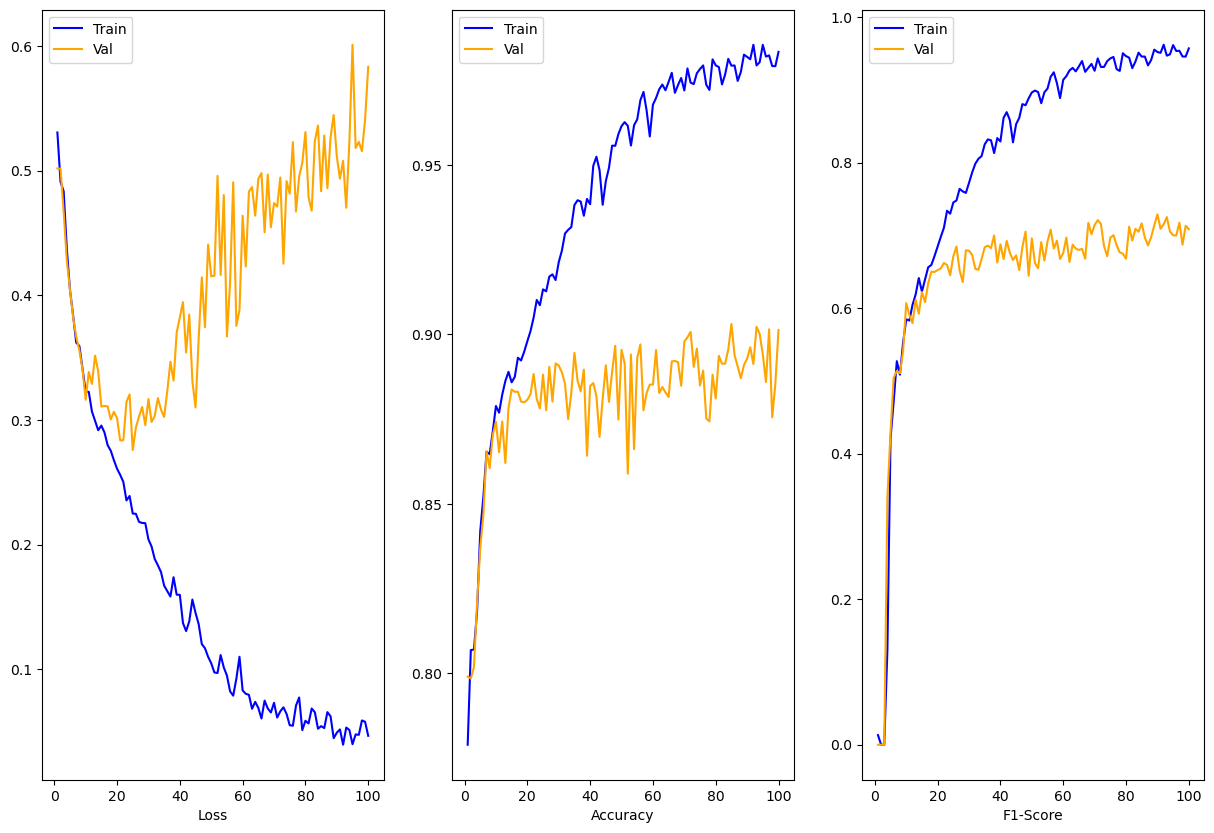

In [11]:
display_metrics(NUM_EPOCHS, metrics)

# Submission

In [12]:
# Create test dataset
dataset_te = EEGDataset(
    clips_te,  # Your test clips variable
    signals_root=DATA_ROOT
    / "test",  # Update this path if your test signals are stored elsewhere
    #signal_transform=fft_filtering,  # You can change or remove the signal_transform as needed
    prefetch=True,  # Set to False if prefetching causes memory issues on your compute environment
    return_id=True,  # Return the id of each sample instead of the label
)

# Create DataLoader for the test dataset
loader_te = DataLoader(dataset_te, batch_size=512, shuffle=False)

In [13]:
# Generate the submission file for Kaggle
model = CombinedModel(gcn_in_features=64, gcn_out_features=32, output_size=1, window_size=125, step_size=62, lstm_input_size=128, lstm_hidden_size=128, attention_dim=64)
model.to(device)
model.load_state_dict(torch.load("models/gcn_lstm/best_model.pt"))
# Set the model to evaluation mode
model.eval()

# Lists to store sample IDs and predictions
all_predictions = []
all_ids = []

# Disable gradient computation for inference
with torch.no_grad():
    for x, ids in loader_te:
        # Assume each batch returns a tuple (x_batch, sample_id)
        # If your dataset does not provide IDs, you can generate them based on the batch index.

        # Move the input data to the device (GPU or CPU)
        x = x.to(torch.float32).to(device)

        # Perform the forward pass to get the model's output logits
        logits = model(x, edge_index)

        # Convert logits to predictions.
        # For binary classification, threshold logits at 0 (adjust this if you use softmax or multi-class).
        predictions = torch.round(torch.sigmoid(logits)).cpu().numpy()

        # Append predictions and corresponding IDs to the lists
        all_predictions.extend(predictions.flatten().tolist())
        all_ids.extend(list(ids))

# Create a DataFrame for Kaggle submission with the required format: "id,label"
submission_df = pd.DataFrame({"id": all_ids, "label": all_predictions})
# submission_df["id"] = submission_df["id"].apply(lambda x: "_".join([txt.replace("_","") for txt in x.split("__")]))
submission_df["label"] = submission_df["label"].astype(int)

submission_df.to_csv("submission_gcn_lstm.csv", index=False)
print("Kaggle submission file generated: submission.csv")

/tmp/ipykernel_1874077/3225168968.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/gcn_lstm/best_model.pt"))


Kaggle submission file generated: submission.csv
